# Oceanstream function tests
# Table of content

In [58]:
# Import modules
import gc
import os
import urllib.request
import glob
import warnings
import pandas as pd

import echopype.visualize as epviz
import fsspec
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np


from oceanstream.echodata import raw_handler, ensure_time_continuity
from oceanstream.echodata import (
    raw_handler,
    ensure_time_continuity,
    sv_computation,
    sv_dataset_extension,
    sv_interpolation,
    processed_data_io
)
from oceanstream.denoise import (
    noise_masks,
    applying_masks_handler,

)
from oceanstream.exports import (
    nasc_computation,
    frequency_differencing_handler,
)

from oceanstream.exports.shoals import (
    shoal_detection_handler,   
)

from oceanstream.denoise.applying_masks_handler import apply_mask_organisms_in_order
from oceanstream.exports.mvbs_computation import compute_mvbs
from oceanstream.utils import add_metadata_to_mask, attach_mask_to_dataset, dict_to_formatted_list

In [3]:
# Load the memory_profiler extension to enable memory usage profiling in the notebook
%load_ext memory_profiler 

In [4]:
import sys
import platform

# Print system information
print("Python Version:", sys.version)
print("Operating System:", platform.platform())

Python Version: 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
Operating System: Windows-10-10.0.19045-SP0


## L0 load raw data

In [5]:
import boto3, botocore
from botocore import UNSIGNED
from botocore.client import Config

s3 = boto3.resource(
    's3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED)
)

BUCKET = 'noaa-wcsd-pds'

rawFiles = [
    'DY1706_EK60-D20170625-T062521.raw',
    'DY1706_EK60-D20170625-T063335.raw',
    'DY1706_EK60-D20170625-T064148.raw'
]
bottomFiles = [
    'DY1706_EK60-D20170625-T062521.bot',
    'DY1706_EK60-D20170625-T063335.bot',
    'DY1706_EK60-D20170625-T064148.bot'
]

try:
    for file in rawFiles + bottomFiles:
        if file not in os.listdir('.'): 
            s3.Bucket(BUCKET).download_file('data/raw/Oscar_Dyson/DY1706/EK60/' + file, file)
            print('downloaded:', file)
        else:
            print('already found:', file)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

already found: DY1706_EK60-D20170625-T062521.raw
already found: DY1706_EK60-D20170625-T063335.raw
already found: DY1706_EK60-D20170625-T064148.raw
already found: DY1706_EK60-D20170625-T062521.bot
already found: DY1706_EK60-D20170625-T063335.bot
already found: DY1706_EK60-D20170625-T064148.bot


## L1A Convert raw to Sonar-netCDF4 or Zarr format 

In [6]:
# Define the directory path
folder_path = r'C:\Users\yy3001\Documents\GitHub\Jupyter notebook archives'
raw_files_path = raw_handler.file_finder(folder_path, file_type='raw')
raw_files_path = [path for path in raw_files_path if 'DY1706' in path and '.evi' not in path]
display(raw_files_path)

['C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T062521.raw',
 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T063335.raw',
 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T064148.raw']

In [7]:
# Verifies if the provided echo sounder files are
# readable by echopype and extracts
# essential metadata such as the campaign ID, date of measurement,
# and sonar model.
raw_files_ck = []
for file_path in raw_files_path:
    raw_files_ck.append(raw_handler.file_integrity_checking(file_path))
    
raw_files_ck

[{'file_path': 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T062521.raw',
  'campaign_id': 'DY1706_EK60',
  'date': datetime.datetime(2017, 6, 25, 6, 25, 21, 886675, tzinfo=<UTC>),
  'file_integrity': True,
  'sonar_model': 'EK60',
  'use_swap': False},
 {'file_path': 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T063335.raw',
  'campaign_id': 'DY1706_EK60',
  'date': datetime.datetime(2017, 6, 25, 6, 33, 35, 350580, tzinfo=<UTC>),
  'file_integrity': True,
  'sonar_model': 'EK60',
  'use_swap': False},
 {'file_path': 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T064148.raw',
  'campaign_id': 'DY1706_EK60',
  'date': datetime.datetime(2017, 6, 25, 6, 41, 48, 828485, tzinfo=<UTC>),
  'file_integrity': True,
  'sonar_model': 'EK60',
  'use_swap': False}]

In [8]:
warnings.filterwarnings("ignore")
# Convert raw data into NC format
raw_handler.convert_raw_files(raw_files_ck, folder_path, save_file_type='nc')

['C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T062521.nc',
 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T063335.nc',
 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T064148.nc']

In [9]:
# Displays all `.nc` files from the "folder_path" directory
nc_files_path = raw_handler.file_finder(folder_path, file_type='nc')
nc_files_path = list(filter(lambda nc_files_path: 'DY1706' in nc_files_path, nc_files_path)) # chose "SHEAR" project data
nc_files_path

['C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T062521.nc',
 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T063335.nc',
 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T064148.nc']

In [10]:
# check data integrity
nc_files_ck = []
for file_path in nc_files_path:
    nc_files_ck.append(raw_handler.file_integrity_checking(file_path))
    
nc_files_ck

[{'file_path': 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T062521.nc',
  'campaign_id': 'DY1706_EK60',
  'date': datetime.datetime(2017, 6, 25, 6, 25, 21),
  'file_integrity': True,
  'sonar_model': None},
 {'file_path': 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T063335.nc',
  'campaign_id': 'DY1706_EK60',
  'date': datetime.datetime(2017, 6, 25, 6, 33, 35),
  'file_integrity': True,
  'sonar_model': None},
 {'file_path': 'C:\\Users\\yy3001\\Documents\\GitHub\\Jupyter notebook archives\\DY1706_EK60-D20170625-T064148.nc',
  'campaign_id': 'DY1706_EK60',
  'date': datetime.datetime(2017, 6, 25, 6, 41, 48),
  'file_integrity': True,
  'sonar_model': None}]

In [11]:
# read into nc format data
ds_nc = raw_handler.read_processed_files(nc_files_path)

In [12]:
for ds in ds_nc:
    if ensure_time_continuity.check_reversed_time(ds, "Sonar/Beam_group1", "ping_time") == True:
        print(ds)

In [13]:
# Cancatenate multiple files
ds = raw_handler.concatenate_files(nc_files_ck)
ensure_time_continuity.check_reversed_time(ds, "Sonar/Beam_group1", "ping_time")
ds

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

## L1B Quality-control steps, such as time-coordinate corrections that enforce strictly increasing, non-duplicate timestamps.

## L2A Compute Sv data

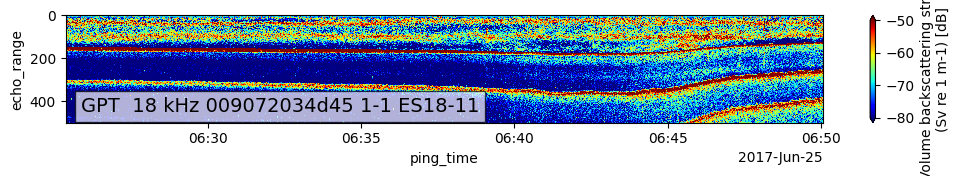

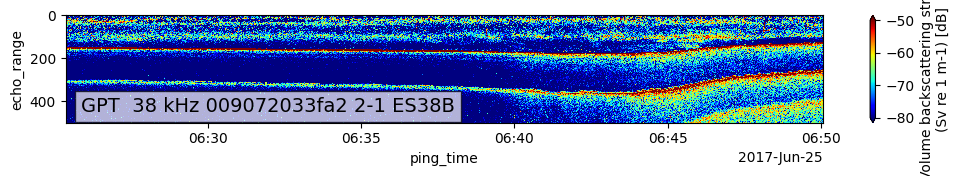

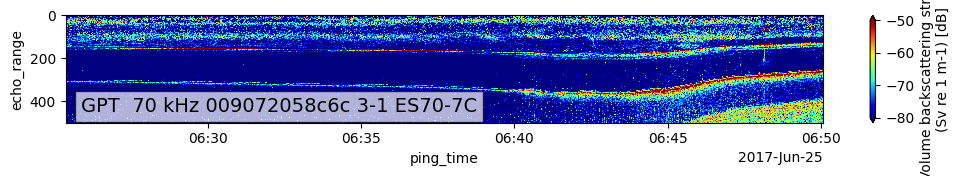

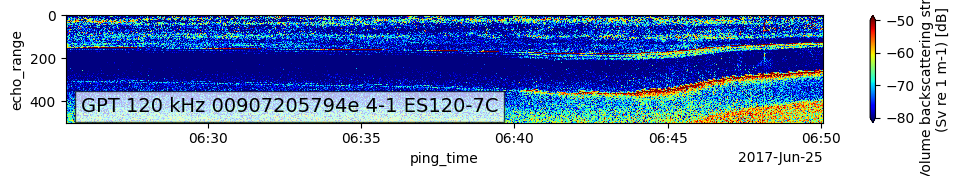

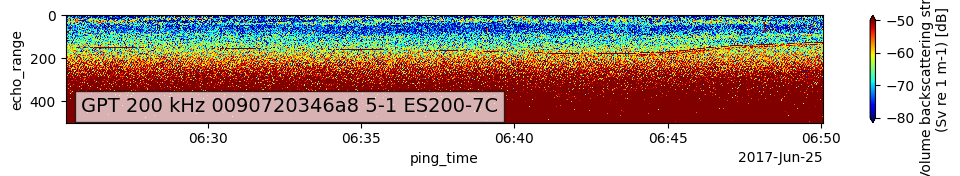

In [14]:
# Volume backscattering strength (Sv) with interpolated latitude, longitude and depth coordinates.
# May incorporate addition information, such as split beam angle
sv = sv_computation.compute_sv(ds)
sv
epviz.create_echogram(sv,vmin=-80,vmax=-50)

In [15]:
extended_sv = sv_dataset_extension.enrich_sv_dataset(sv = sv, 
                                                     echodata = ds, 
                                                     waveform_mode="CW", 
                                                     encode_mode="power")

In [16]:
extended_sv

<xarray.Dataset> Size: 2GB
Dimensions:                        (channel: 5, ping_time: 1476,
                                    range_sample: 5293, filenames: 1)
Coordinates:
  * channel                        (channel) <U37 740B 'GPT  18 kHz 009072034...
  * ping_time                      (ping_time) datetime64[ns] 12kB 2017-06-25...
  * range_sample                   (range_sample) int32 21kB 0 1 2 ... 5291 5292
  * filenames                      (filenames) int32 4B 0
Data variables: (12/21)
    Sv                             (channel, ping_time, range_sample) float64 312MB ...
    echo_range                     (channel, ping_time, range_sample) float64 312MB ...
    frequency_nominal              (channel) float64 40B 1.8e+04 ... 2e+05
    sound_speed                    (channel, ping_time) float64 59kB 1.476e+0...
    sound_absorption               (channel, ping_time) float64 59kB 0.002768...
    sa_correction                  (ping_time, channel) float64 59kB -0.45 .....
    ...                             ...
    water_level                    float64 8B 9.15
    depth                          (channel, ping_time, range_sample) float64 312MB ...
    latitude                       (ping_time) float64 12kB nan 55.37 ... 55.3
    longitude                      (ping_time) float64 12kB nan ... -159.5
    angle_alongship                (channel, ping_time, range_sample) float64 312MB ...
    angle_athwartship              (channel, ping_time, range_sample) float64 312MB ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  unknown
    processing_time:              2024-05-19T18:10:29Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [17]:
# extended_sv.attrs['processing_level']

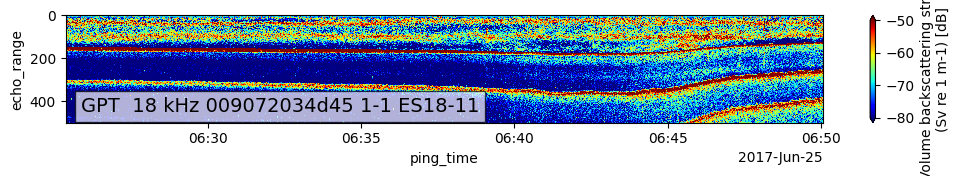

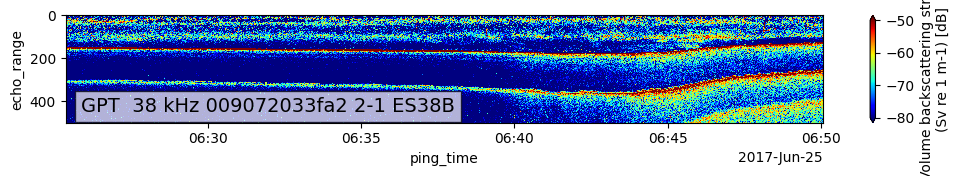

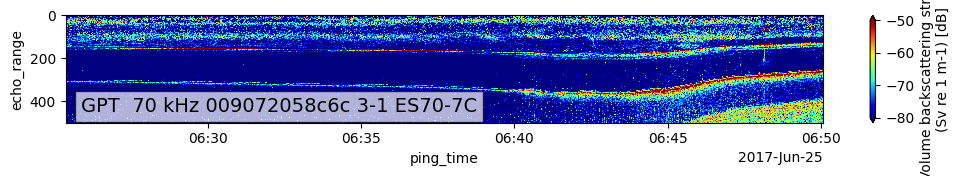

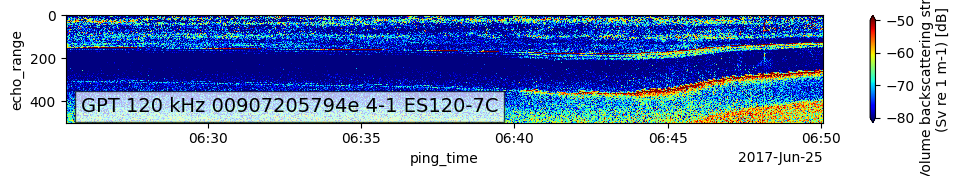

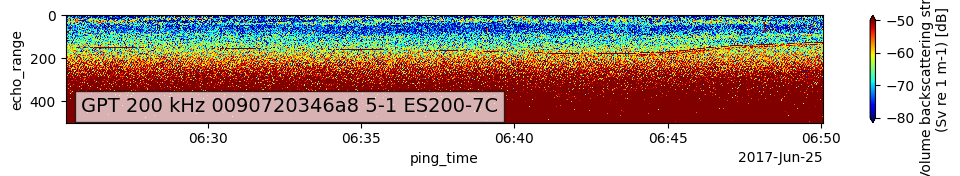

In [18]:
sv_60_ds = sv
extended_sv_60_ds = extended_sv
epviz.create_echogram(sv_60_ds,vmin=-80,vmax=-50)

In [19]:
extended_sv_60_ds

<xarray.Dataset> Size: 2GB
Dimensions:                        (channel: 5, ping_time: 1476,
                                    range_sample: 5293, filenames: 1)
Coordinates:
  * channel                        (channel) <U37 740B 'GPT  18 kHz 009072034...
  * ping_time                      (ping_time) datetime64[ns] 12kB 2017-06-25...
  * range_sample                   (range_sample) int32 21kB 0 1 2 ... 5291 5292
  * filenames                      (filenames) int32 4B 0
Data variables: (12/21)
    Sv                             (channel, ping_time, range_sample) float64 312MB ...
    echo_range                     (channel, ping_time, range_sample) float64 312MB ...
    frequency_nominal              (channel) float64 40B 1.8e+04 ... 2e+05
    sound_speed                    (channel, ping_time) float64 59kB 1.476e+0...
    sound_absorption               (channel, ping_time) float64 59kB 0.002768...
    sa_correction                  (ping_time, channel) float64 59kB -0.45 .....
    ...                             ...
    water_level                    float64 8B 9.15
    depth                          (channel, ping_time, range_sample) float64 312MB ...
    latitude                       (ping_time) float64 12kB nan 55.37 ... 55.3
    longitude                      (ping_time) float64 12kB nan ... -159.5
    angle_alongship                (channel, ping_time, range_sample) float64 312MB ...
    angle_athwartship              (channel, ping_time, range_sample) float64 312MB ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  unknown
    processing_time:              2024-05-19T18:10:29Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

## L2B Noise removal

### Creat noise masks (transient, attenuation, impulse noise masks) 

In [28]:
warnings.filterwarnings("ignore")
oceanstream_ek60_extended_ds = noise_masks.create_noise_masks_oceanstream(extended_sv_60_ds)
oceanstream_ek60_extended_ds

<xarray.Dataset> Size: 2GB
Dimensions:                        (channel: 5, ping_time: 1476,
                                    range_sample: 5293, filenames: 1)
Coordinates:
  * channel                        (channel) object 40B 'GPT  18 kHz 00907203...
  * ping_time                      (ping_time) datetime64[ns] 12kB 2017-06-25...
  * range_sample                   (range_sample) int32 21kB 0 1 2 ... 5291 5292
  * filenames                      (filenames) int32 4B 0
Data variables: (12/24)
    Sv                             (channel, ping_time, range_sample) float64 312MB ...
    echo_range                     (channel, ping_time, range_sample) float64 312MB ...
    frequency_nominal              (channel) float64 40B 1.8e+04 ... 2e+05
    sound_speed                    (channel, ping_time) float64 59kB 1.476e+0...
    sound_absorption               (channel, ping_time) float64 59kB 0.002768...
    sa_correction                  (ping_time, channel) float64 59kB -0.45 .....
    ...                             ...
    longitude                      (ping_time) float64 12kB nan ... -159.5
    angle_alongship                (channel, ping_time, range_sample) float64 312MB ...
    angle_athwartship              (channel, ping_time, range_sample) float64 312MB ...
    mask_transient                 (channel, ping_time, range_sample) bool 39MB ...
    mask_attenuation               (channel, ping_time, range_sample) bool 39MB ...
    mask_impulse                   (channel, ping_time, range_sample) bool 39MB ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  unknown
    processing_time:              2024-05-19T18:10:29Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

### Seabed and surface data removal

In [29]:
# seabed, false seabed masks
# `blackwell`

BLACKWELL_DEFAULT_PARAMS = {
    "r0": 10,
    "r1": 1000,
    "tSv": -35,
    "ttheta": 702,
    "tphi": 282,
    "wtheta": 28,
    "wphi": 52,
}

blackwell_mask = noise_masks.create_seabed_mask(
    oceanstream_ek60_extended_ds,
    method="blackwell",
    parameters = BLACKWELL_DEFAULT_PARAMS,
    )
blackwell_mask = add_metadata_to_mask(
    mask=blackwell_mask , 
    metadata={
        "mask_type": "false_seabed", 
        "method":"blackwell",
        "parameters": dict_to_formatted_list(BLACKWELL_DEFAULT_PARAMS),
    }
)

oceanstream_ek60_extended_ds = attach_mask_to_dataset(
    oceanstream_ek60_extended_ds, 
    blackwell_mask
)


# `ariza`

ARIZA_PARAMS = {
    "r0": 10,
    "r1": 1000,
    "roff": 0,
    "thr": (-40, -40),
    "ec": 1,
    "ek": (3, 3),
    "dc": 3,
    "dk": (3, 3),
    "maximum_spike": 100,
}
ariza_mask = noise_masks.create_seabed_mask(
    oceanstream_ek60_extended_ds,
    method="ariza",
    parameters=ARIZA_PARAMS,
)
ariza_mask = add_metadata_to_mask(
    mask=ariza_mask,
    metadata={
        "mask_type": "seabed",
        "method": "ariza",
        "parameters": dict_to_formatted_list(ARIZA_PARAMS),
    },
)

oceanstream_ek60_extended_ds = attach_mask_to_dataset(
    oceanstream_ek60_extended_ds, 
    ariza_mask
)

oceanstream_ek60_extended_ds

<xarray.Dataset> Size: 2GB
Dimensions:                        (channel: 5, ping_time: 1476,
                                    range_sample: 5293, filenames: 1)
Coordinates:
  * channel                        (channel) object 40B 'GPT  18 kHz 00907203...
  * ping_time                      (ping_time) datetime64[ns] 12kB 2017-06-25...
  * range_sample                   (range_sample) int32 21kB 0 1 2 ... 5291 5292
  * filenames                      (filenames) int32 4B 0
Data variables: (12/26)
    Sv                             (channel, ping_time, range_sample) float64 312MB ...
    echo_range                     (channel, ping_time, range_sample) float64 312MB ...
    frequency_nominal              (channel) float64 40B 1.8e+04 ... 2e+05
    sound_speed                    (channel, ping_time) float64 59kB 1.476e+0...
    sound_absorption               (channel, ping_time) float64 59kB 0.002768...
    sa_correction                  (ping_time, channel) float64 59kB -0.45 .....
    ...                             ...
    angle_athwartship              (channel, ping_time, range_sample) float64 312MB ...
    mask_transient                 (channel, ping_time, range_sample) bool 39MB ...
    mask_attenuation               (channel, ping_time, range_sample) bool 39MB ...
    mask_impulse                   (channel, ping_time, range_sample) bool 39MB ...
    mask_false_seabed              (channel, ping_time, range_sample) bool 39MB ...
    mask_seabed                    (channel, ping_time, range_sample) int32 156MB ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  unknown
    processing_time:              2024-05-19T18:10:29Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [30]:
process_parameters = {
    'mask_false_seabed': {
    'var_name': 'Sv',
    },
    'mask_seabed': {
    'var_name': 'Sv',
    },
}

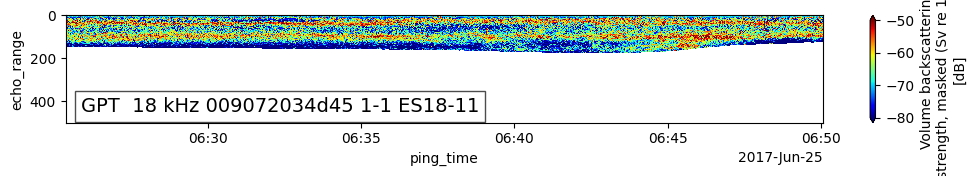

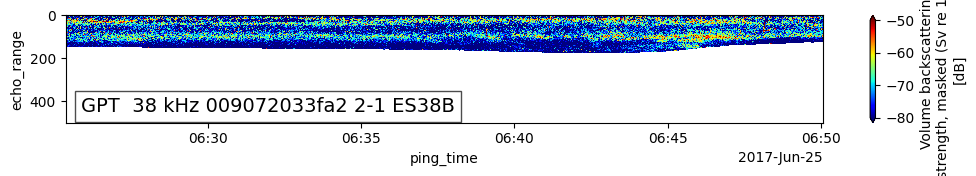

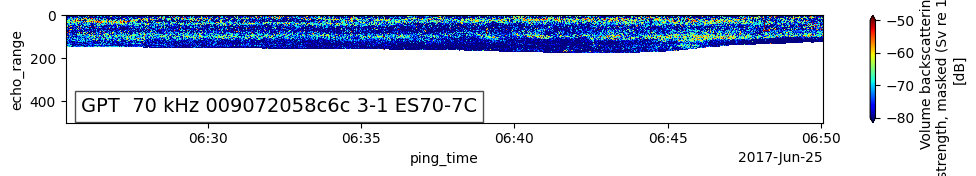

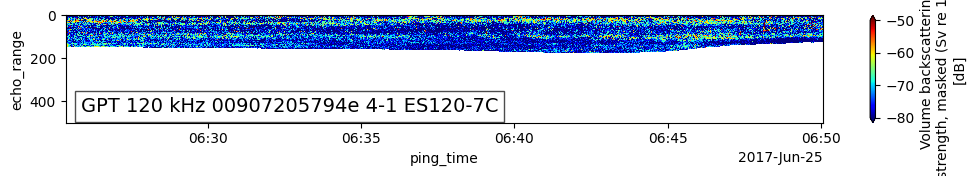

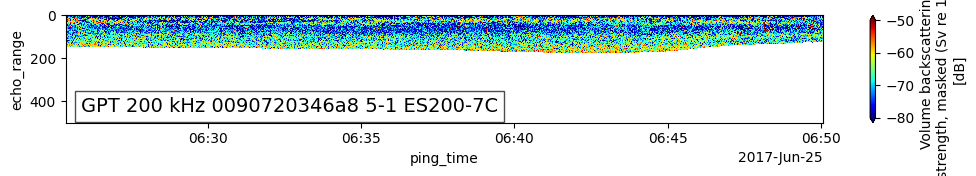

In [31]:
ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    oceanstream_ek60_extended_ds, 
    process_parameters
)
epviz.create_echogram(ds,vmin=-80,vmax=-50)

In [32]:
# create seasurface mask and remove data above certain surface line
surface_mask = ds['echo_range'] <= 10

# Modify Sv values in the DataArray where echo_range <= 10 to -999
ds['Sv'] = xr.where(surface_mask, -999, ds['Sv'])
seabed_ds = ds
#epviz.create_echogram(ds,vmin=-80,vmax=-50)

### Background noise removal

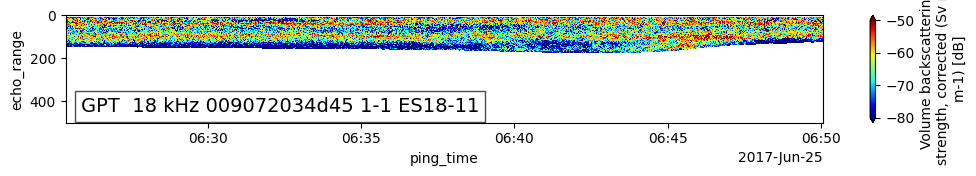

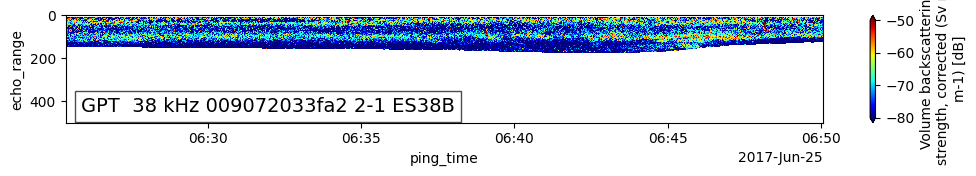

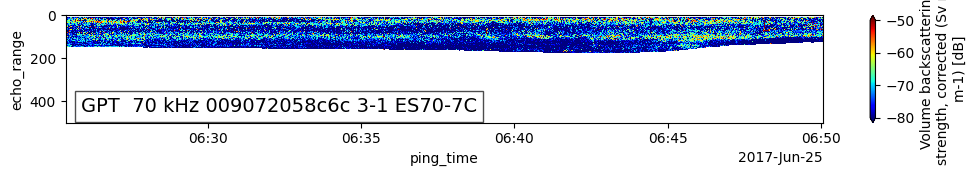

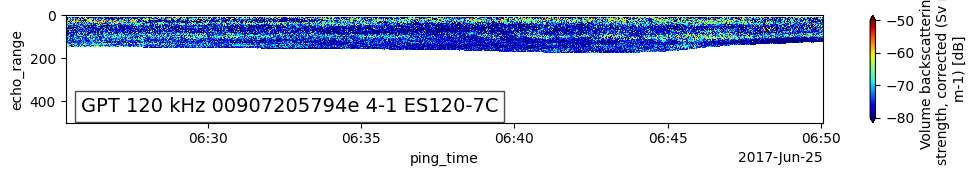

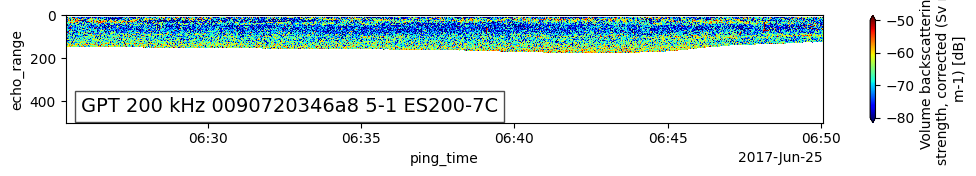

In [33]:
process_parameters = {
        "remove_background_noise": {
        "ping_num": 40,
        # "range_sample_num": 10,
        "noise_max": -125,
        "SNR_threshold": 3,
    },

}
background_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    seabed_ds, 
    process_parameters
)

epviz.create_echogram(background_ds,vmin=-80,vmax=-50)

### Transient, Impulse and Attenuation noise removal

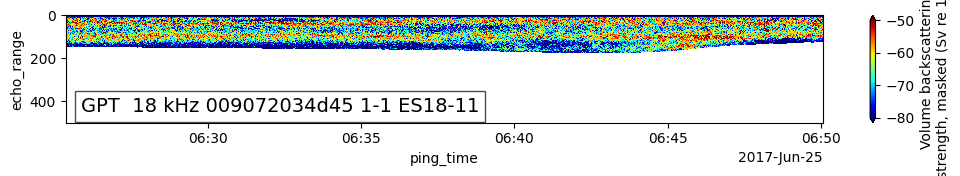

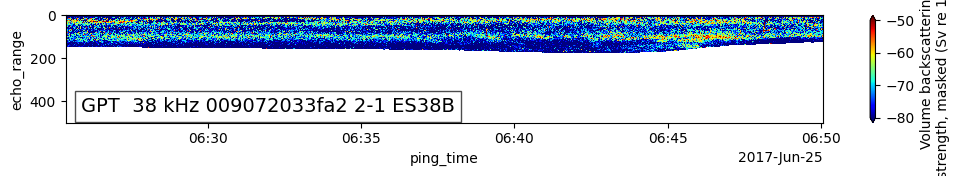

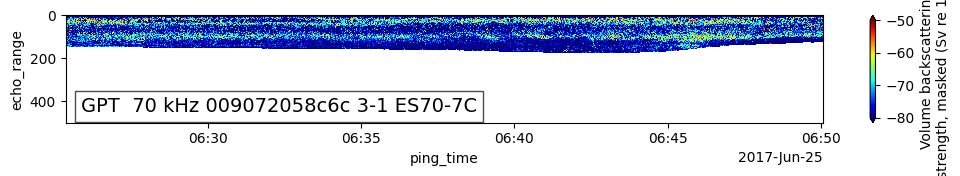

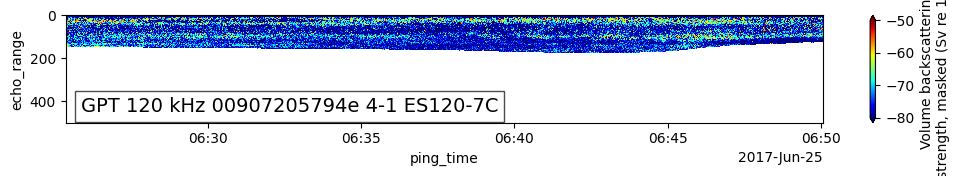

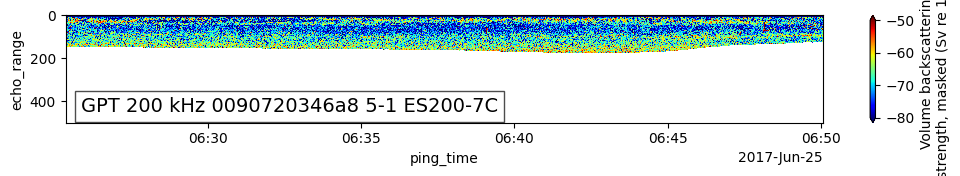

In [34]:
process_parameters = {
    "mask_transient": {
        "var_name": "Sv",
    },
}
transient_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    seabed_ds, 
    process_parameters
)
epviz.create_echogram(transient_ds,vmin=-80,vmax=-50)

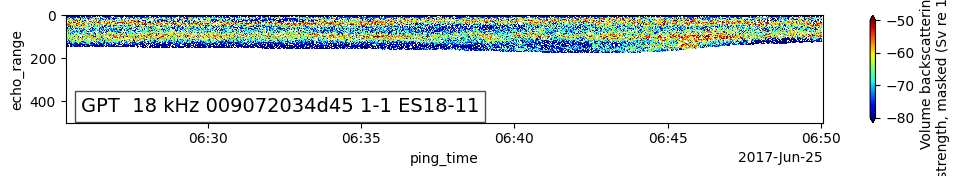

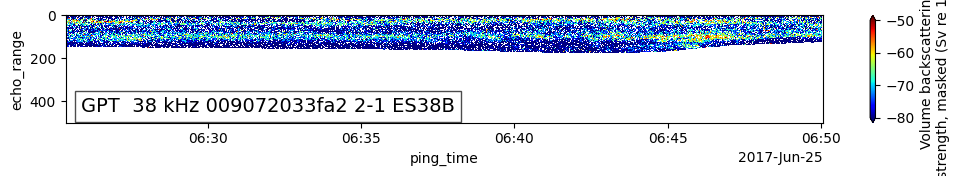

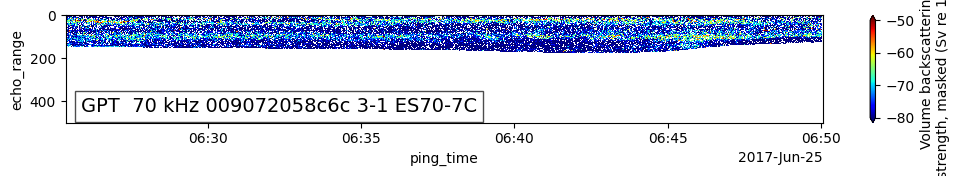

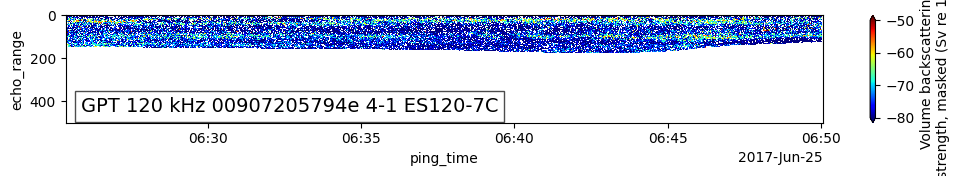

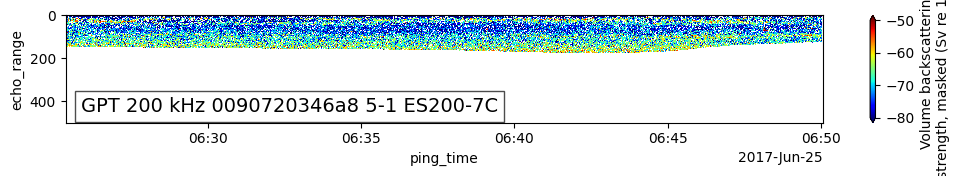

In [35]:
process_parameters = {
    "mask_impulse": {
        "var_name": "Sv",
    },
}
impulse_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    seabed_ds, 
    process_parameters
)
epviz.create_echogram(impulse_ds,vmin=-80,vmax=-50)

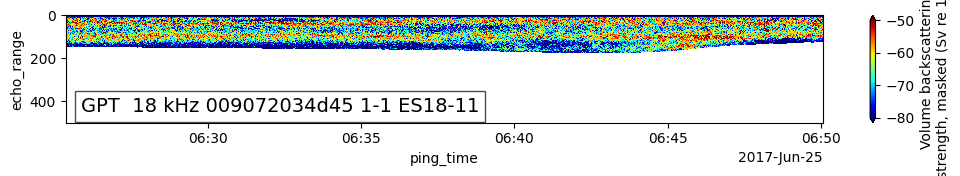

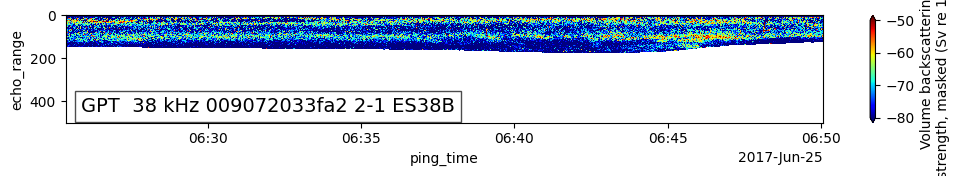

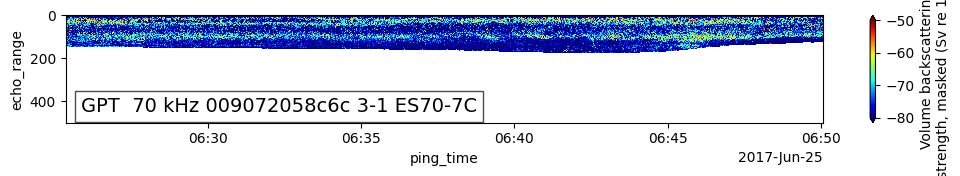

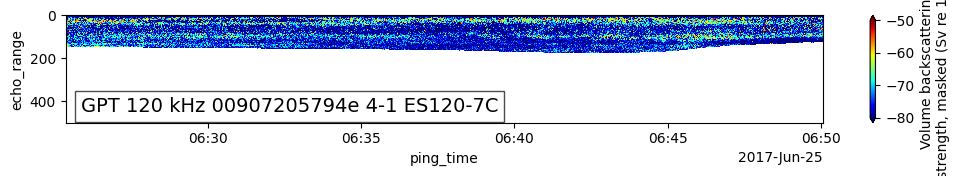

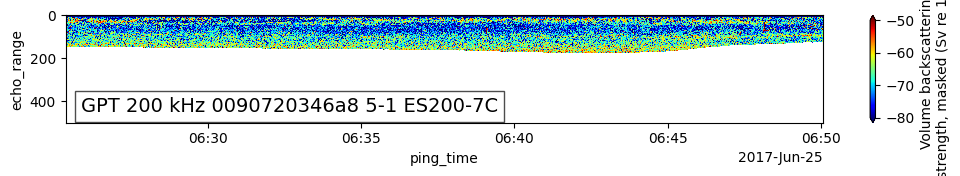

In [36]:
process_parameters = {
    "mask_attenuation": {
        "var_name": "Sv",
    },
}
attenuation_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    seabed_ds, 
    process_parameters
)
epviz.create_echogram(attenuation_ds,vmin=-80,vmax=-50)

###  Remove all noises and at one go

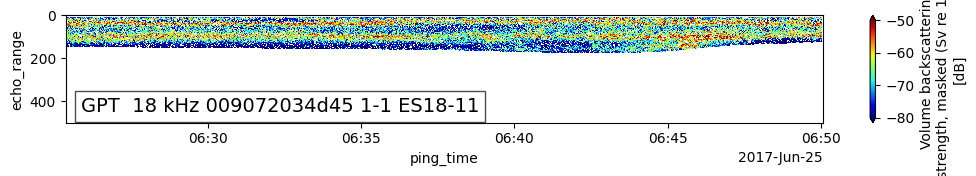

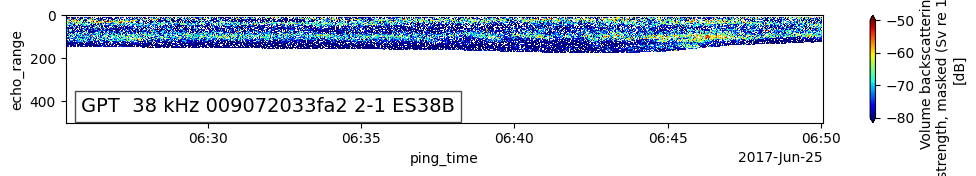

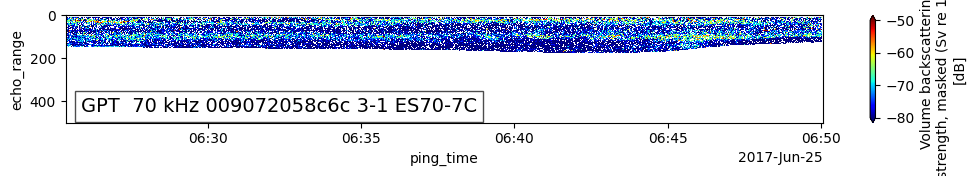

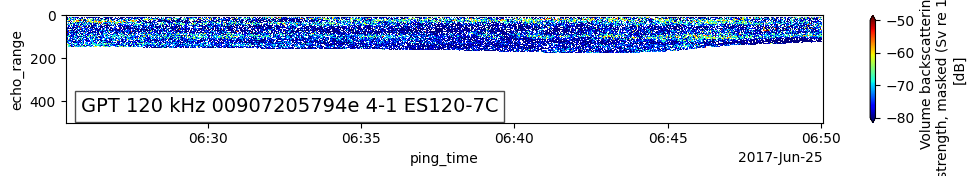

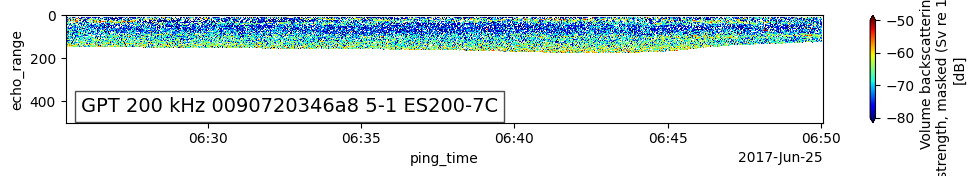

In [37]:
#  remove transient, impulse, attenuation, backgound noise and seabed at once
process_parameters = {
    'mask_false_seabed': {
    'var_name': 'Sv',
    },
    'mask_seabed': {
    'var_name': 'Sv',
    },
    "remove_background_noise": {
    "ping_num": 40,
    # "range_sample_num": 10,
    "noise_max": -125,
    "SNR_threshold": 3,
    },
    "mask_transient": {
        "var_name": "Sv",
    },
    "mask_impulse": {
        "var_name": "Sv",
    },
    "mask_attenuation": {
        "var_name": "Sv",
    },
}

cleaned_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    seabed_ds, 
    process_parameters
)
epviz.create_echogram(cleaned_ds,vmin=-80,vmax=-50)

### Interpolation 

In [ ]:
# interpolated_ds = sv_interpolation.interpolate_sv(cleaned_ds)
# interpolated_ds
# epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

## L3 Regridded or aggregated to a common grid across channels

In [38]:
# Compute NASC for whole region
nasc_seabed = nasc_computation.compute_per_dataset_nasc(seabed_ds)
nasc_seabed['NASC_dataset']['NASC']

nasc_background = nasc_computation.compute_per_dataset_nasc(background_ds)
nasc_background['NASC_dataset']['NASC']

nasc_impulse = nasc_computation.compute_per_dataset_nasc(impulse_ds)
nasc_impulse['NASC_dataset']['NASC']

nasc_attenuation = nasc_computation.compute_per_dataset_nasc(attenuation_ds)
nasc_attenuation['NASC_dataset']['NASC']

nasc_transient = nasc_computation.compute_per_dataset_nasc(transient_ds)
nasc_transient['NASC_dataset']['NASC']

nasc_cleaned = nasc_computation.compute_per_dataset_nasc(cleaned_ds)
nasc_cleaned['NASC_dataset']['NASC']

<xarray.DataArray 'NASC' (channel: 5, distance: 1, depth: 1)> Size: 40B
array([[[16844.50599344]],

       [[ 3599.78419804]],

       [[ 2583.46075308]],

       [[ 2514.88890649]],

       [[ 6442.27487907]]])
Coordinates:
  * distance  (distance) float64 8B 0.0
  * channel   (channel) object 40B 'GPT  18 kHz 009072034d45 1-1 ES18-11' ......
  * depth     (depth) float64 8B 0.0
Attributes:
    long_name:     Nautical Areal Scattering Coefficient (NASC, m2 nmi-2)
    units:         m2 nmi-2
    actual_range:  [2514.889, 16844.506]

In [39]:
# Compute by grid
# Seabed removed raw data
MVBS_seabed = compute_mvbs(
    seabed_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")

# Background noise removed 
MVBS_background = compute_mvbs(
    background_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")

# Impulse noise removed 
MVBS_impulse = compute_mvbs(
    impulse_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")

# Transient noise removed 
MVBS_transient = compute_mvbs(
    transient_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")

# Attenuation signal removed 
MVBS_attenuation = compute_mvbs(
    attenuation_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")

# All noise algorithms applied 
MVBS_cleaned = compute_mvbs(
    cleaned_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")

In [ ]:
cleaned_ds["Sv"].count()/cleaned_ds["Sv"].size

### Multi-frequency dB-differencing 

In [43]:
chan120 = cleaned_ds['channel'][3].item()
chan38 = cleaned_ds['channel'][1].item()
ds_Sv_with_krill_mask = frequency_differencing_handler.identify_krill(cleaned_ds, chan120=chan120, chan38=chan38)

ds_Sv_with_gas_bearing_organisms_mask = frequency_differencing_handler.identify_gas_bearing_organisms(
    ds_Sv_with_krill_mask,
    chan120=chan120,
    chan38=chan38
)

ds_Sv_with_fluid_like_organisms_mask = frequency_differencing_handler.identify_fluid_like_organisms(
    ds_Sv_with_gas_bearing_organisms_mask,
    chan120=chan120,
    chan38=chan38
)



### School detection (shoal algorithm) 

CPU times: total: 13.4 s
Wall time: 12.3 s


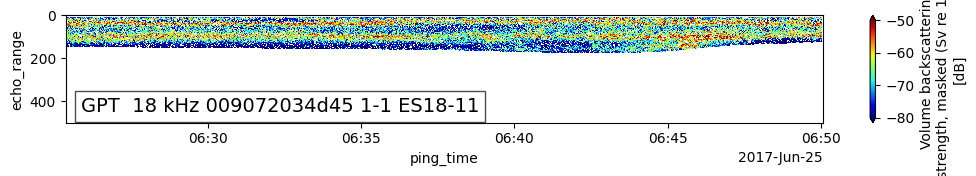

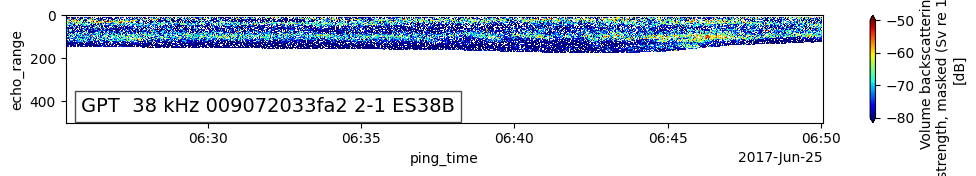

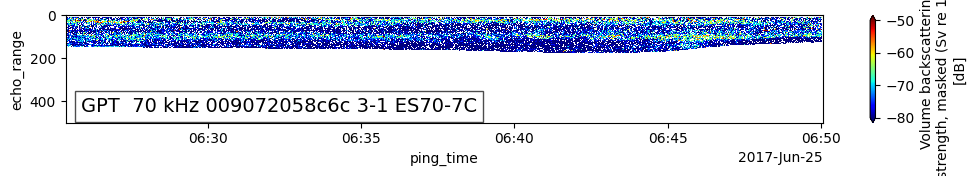

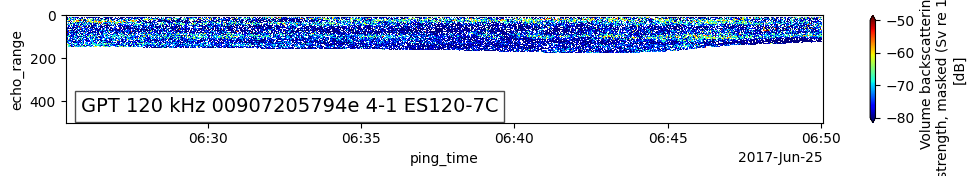

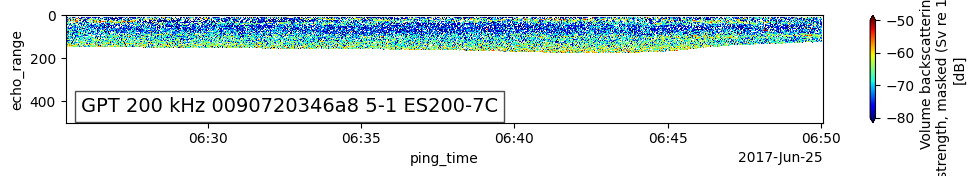

In [44]:
%%time

WEILL_DEFAULT_PARAMETERS = {
    "thr": -70,
    "maxvgap": 5,
    "maxhgap": 1,
    "minvlen": 15,
    "minhlen": 3,
    "dask_chunking": {"ping_time": 1000, "range_sample": 1000},
}

ds_Sv_with_shoal_combined_mask = shoal_detection_handler.attach_shoal_mask_to_ds(ds_Sv_with_fluid_like_organisms_mask, WEILL_DEFAULT_PARAMETERS)
ds_Sv_with_shoal_combined_mask
epviz.create_echogram(ds_Sv_with_shoal_combined_mask,vmin=-80,vmax=-50)

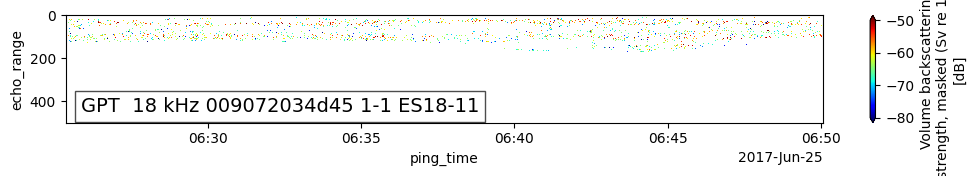

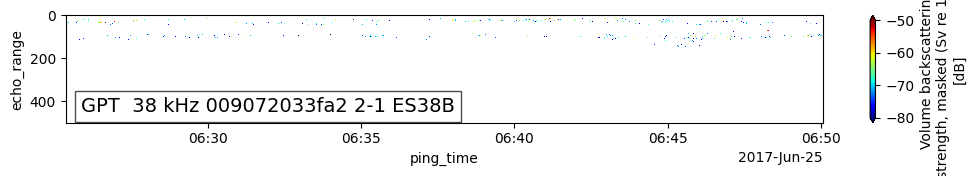

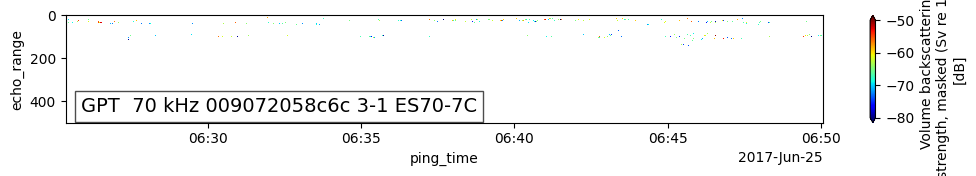

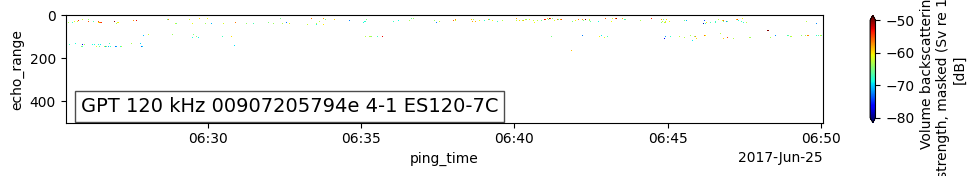

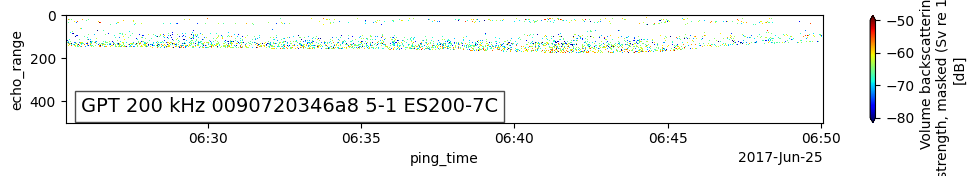

In [45]:
process_parameters = {
    'mask_krill': {
        'var_name': 'Sv',
    },
    'mask_shoal': {
        'var_name': 'Sv',
    }
}

organisms_ds = apply_mask_organisms_in_order(ds_Sv_with_shoal_combined_mask, process_parameters)
epviz.create_echogram(organisms_ds,vmin=-80,vmax=-50)

In [46]:
krill_nasc = nasc_computation.compute_per_dataset_nasc(organisms_ds)
krill_nasc['NASC_dataset']['NASC']

<xarray.DataArray 'NASC' (channel: 5, distance: 1, depth: 1)> Size: 40B
array([[[28617.09104084]],

       [[ 5479.23714469]],

       [[16490.04484144]],

       [[22075.50447693]],

       [[11598.78621607]]])
Coordinates:
  * distance  (distance) float64 8B 0.0
  * channel   (channel) object 40B 'GPT  18 kHz 009072034d45 1-1 ES18-11' ......
  * depth     (depth) float64 8B 0.0
Attributes:
    long_name:     Nautical Areal Scattering Coefficient (NASC, m2 nmi-2)
    units:         m2 nmi-2
    actual_range:  [5479.237, 28617.091]

In [47]:
# compute by grid 
MVBS_krill = compute_mvbs(
    organisms_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")
MVBS_krill

<xarray.Dataset> Size: 77kB
Dimensions:            (channel: 5, ping_time: 75, echo_range: 25)
Coordinates:
  * ping_time          (ping_time) datetime64[ns] 600B 2017-06-25T06:25:20 .....
  * channel            (channel) object 40B 'GPT  18 kHz 009072034d45 1-1 ES1...
  * echo_range         (echo_range) float64 200B 0.0 20.0 40.0 ... 460.0 480.0
Data variables:
    Sv                 (channel, ping_time, echo_range) float64 75kB -56.98 ....
    latitude           (ping_time) float64 600B 55.37 55.37 55.37 ... 55.3 55.3
    longitude          (ping_time) float64 600B -159.4 -159.4 ... -159.5 -159.5
    water_level        float64 8B 9.15
    frequency_nominal  (channel) float64 40B 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
Attributes:
    processing_software_name:     echopype
    processing_software_version:  unknown
    processing_time:              2024-05-19T21:26:42Z
    processing_function:          commongrid.compute_MVBS
    processing_level:             Level 3B
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

## L4 Acoustically derived biological features

## Workflow diagram

In [48]:
import base64
from IPython.display import Image, display

def mm_ink(graphbytes):
  """Given a bytes object holding a Mermaid-format graph, return a URL that will generate the image."""
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  return "https://mermaid.ink/img/" + base64_string

def mm_display(graphbytes):
  """Given a bytes object holding a Mermaid-format graph, display it."""
  display(Image(url=mm_ink(graphbytes)))

def mm(graph):
  """Given a string containing a Mermaid-format graph, display it."""
  graphbytes = graph.encode("ascii")
  mm_display(graphbytes)

def mm_link(graph):
  """Given a string containing a Mermaid-format graph, return URL for display."""
  graphbytes = graph.encode("ascii")
  return mm_ink(graphbytes)
  
def mm_path(path):
  """Given a path to a file containing a Mermaid-format graph, display it"""
  with open(path, 'rb') as f:
    graphbytes = f.read()
  mm_display(graphbytes)

mm("""
graph TD;
    A[(Raw data)] -- L1A process --> B[Sonar Net-CDF4 or Zarr];
    B-- L1B process--> C[Quality control];
    C-- L2A process--> D[Compute Sv];
    D-- L2B process--> E[Create noise masks];
    E--> F[Seabed and sea surface data removal];
    E--> G[Transient noise removal];
    E--> H[Impulse noise removal];
    E--> I[Attenuation noise removal];
    F --> J[Grided data];
    G --> J;
    H --> J;
    I --> J;
    J--> K[Multifrequency dB-differencing];
    K--> L[School/Shoal detection];
    L--> M[Biological derived features];
""")

# Comparison of oceanstream and Echoview processed outputs 

## Oceanstream and Echoview output types

- **Oceanstram processed data includes:**  
seabed_ds
background_ds # background removed     
transient_ds  
impulse_ds  
seabed_ds  
cleaned_ds  
MVBS_krill

- **Echoview processed data includes:**
seabed_18, 38, 70, 120, 200.gridded  
background_18, 38, 70, 120, 200.gridded    
transient_18, 38, 70, 120, 200.gridded      
impulse_18, 38, 70, 120, 200.gridded        
attenuation_18, 38, 70, 120, 200.gridded        
cleaned_18, 38, 70, 120, 200.gridded
krill_gridded        

In [49]:
%whos 

Variable                                Type                  Data/Info
-----------------------------------------------------------------------
ARIZA_PARAMS                            dict                  n=9
BLACKWELL_DEFAULT_PARAMS                dict                  n=7
BUCKET                                  str                   noaa-wcsd-pds
Config                                  type                  <class 'botocore.config.Config'>
Image                                   type                  <class 'IPython.core.display.Image'>
MVBS_attenuation                        Dataset               <xarray.Dataset> Size: 77<...>thedocs.io/en/stable/p...
MVBS_background                         Dataset               <xarray.Dataset> Size: 77<...>thedocs.io/en/stable/p...
MVBS_cleaned                            Dataset               <xarray.Dataset> Size: 77<...>thedocs.io/en/stable/p...
MVBS_impulse                            Dataset               <xarray.Dataset> Size: 77<...>thedocs.

In [ ]:
cleaned_ds["Sv"].count()/cleaned_ds["Sv"].size

In [151]:
# Preprocess Echoview exported Sv data
# Initialize an empty list to store DataArrays
dir = r'C:\Users\yy3001\Documents\GitHub\Jupyter notebook archives'
data_arrays = []

# reorder freuqencies
Sv_list = sorted([filename for filename in os.listdir(dir) if filename.endswith('.sv.csv')], key=lambda x: int(x.split('.')[1]))

# Iterate over files in the directory
for filename in Sv_list:
        # Construct the full file path
        file_path = os.path.join(dir, filename)
        # Give depth index to Sv matrix
        sequence = np.linspace(0.047232, 499.9507187, 5292)

        # Define the list of column names
        names = ["Ping_index", "Distance_gps", "Distance_vl", "Ping_date", "Ping_time", "Ping_milliseconds",
         "Latitude", "Longitude", "Depth_start", "Depth_stop", "Range_start", "Range_stop", "Sample_count"]

        # Append the sequence names to the list of column names
        names.extend([f"Column_{i}" for i in range(len(sequence))])
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path, names=names, skiprows=1)
        # Print the shape of the DataFrame
        print(f"Shape of {filename}: {df.shape}")
        # Preprocess the DataFrame as needed
        Sv = df.drop(df.columns[1:13], axis=1)
        # Remove the first row from the DataFrame
        Sv = Sv.iloc[1:]
        
        # Transpose the DataFrame
        Sv_transformed = Sv.T
        Sv_transformed = Sv_transformed.iloc[1:]
        #df['Time_M'] = pd.to_datetime('1970-01-01 ' + df['Time_M'])
        #ping_time = pd.to_datetime(df['Ping_time']).values
    
        # Create a DataArray for the transformed Sv data
        data_array = xr.DataArray(
            data=Sv_transformed,
            dims=["echo_range", "ping_time"],
            coords=dict(
                    ping_time=pd.to_datetime(df['Ping_time'])[1:],
                    echo_range=[0.047232 + i * ((499.9507187 - 0.047232) / (5292 - 1)) for i in range(5292)],
            ),
            attrs=dict(
                    description="Echoview export",
            )
        )
        # Append the DataArray to the list
        data_arrays.append(data_array)

# Concatenate the list of DataArrays along the 'channel' dimension
combined_data = xr.concat(data_arrays, dim='channel')

# # Convert to Dataset and specify variable name as 'Sv'
# echoview = xr.Dataset({'Sv': combined_data})
# # Print the Dataset
# echoview


final_xarray = combined_data.rename('Sv')

# # Then, create a Dataset using the named DataArray
final_dataset = final_xarray.to_dataset()



Shape of cleaned.18.sv.csv: (1476, 5305)


C:\Users\yy3001\AppData\Local\Temp\ipykernel_32284\3232132878.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ping_time=pd.to_datetime(df['Ping_time'])[1:],


Shape of cleaned.38.sv.csv: (1476, 5305)


C:\Users\yy3001\AppData\Local\Temp\ipykernel_32284\3232132878.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ping_time=pd.to_datetime(df['Ping_time'])[1:],


Shape of cleaned.70.sv.csv: (1476, 5305)


C:\Users\yy3001\AppData\Local\Temp\ipykernel_32284\3232132878.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ping_time=pd.to_datetime(df['Ping_time'])[1:],


Shape of cleaned.120.sv.csv: (1476, 5305)


C:\Users\yy3001\AppData\Local\Temp\ipykernel_32284\3232132878.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ping_time=pd.to_datetime(df['Ping_time'])[1:],


Shape of cleaned.200.sv.csv: (1476, 5305)


C:\Users\yy3001\AppData\Local\Temp\ipykernel_32284\3232132878.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ping_time=pd.to_datetime(df['Ping_time'])[1:],


## Sv data by grid

In [ ]:
## Introduce functions to make Echoview exported data into xarrayDataset for comparison between Oceanstream and Echoview

In [51]:
# define a function to fill in the missing rows that has been exported by Echoview, to make it an intact matrix
def complete_layer(df, max_layer, height):
    '''
    Parameters:
    - df (Dataframe): Echoview exported grided data
    - max_layer (num): Maximum depth of the water layer

    Returns:
    - df (Dataframe): Completed dataframe missing value filled with -999
    '''
    if max_layer < df["Layer"].max():
        print(max_layer, "meter is smaller than the exsiting layer, adjust the depth!!")
    
    import warnings  # Import warnings within the function
    # Start iterating from the first row
    index = 0
    while index < len(df) - 1:
        # Check if the difference between the next row's Layer and the current row's Layer is 1
        if df.loc[index + 1, "Layer"] - df.loc[index, "Layer"] == 1:
            index += 1
        else:
            # Calculate the number of new rows to add
            num_new_rows = max_layer - df.loc[index, "Layer"]
            new_row = df.loc[index].copy()
            new_rows = pd.DataFrame([new_row] * num_new_rows, columns=df.columns)
            new_rows["Layer"] += range(1, num_new_rows + 1)
            new_rows["Sv_mean"] = np.nan
            new_rows["Layer_depth_max"] += range(height, (num_new_rows+1)*height, height)
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                df = pd.concat([df.iloc[:index + 1], new_rows, df.iloc[index + 1:]], ignore_index=True)
            index += 2

    # Check if the last Layer value is less than the maximum layer value
    while df["Layer"].iloc[-1] < max_layer:
        num_new_rows = max_layer - df["Layer"].iloc[-1]
        new_row = df.iloc[-1].copy()  # Copy the last row
        new_rows = pd.DataFrame([new_row] * num_new_rows, columns=df.columns)
        new_rows["Layer"] += range(1, num_new_rows + 1)  # Increment the Layer value
        new_rows["Sv_mean"] = np.nan
        new_rows["Layer_depth_max"] += range(height, (num_new_rows+1)*height, height)
        df = pd.concat([df, new_rows])
        # Check if the new last Layer value equals max_layer, if yes, stop the loop
        if df["Layer"].iloc[-1] == max_layer:
            break

    return df

In [52]:
def create_xarray_dataset(csv_files, directory, max_layer, height):
    data_arrays = []
    for file in csv_files:
        df = pd.read_csv(os.path.join(directory, file))
        df = pd.DataFrame(df)
        df = complete_layer(df, max_layer, height) 
        
        df['DateTime'] = pd.to_datetime(df['Date_M'].astype(str) + ' ' + df['Time_M'], format='%Y%m%d %H:%M:%S.%f')
        data_array = df.pivot(index='Layer_depth_max', columns='DateTime', values='Sv_mean')

        # Create DataArray for the current file
        data_array = xr.DataArray(
            data=data_array,
            coords=dict(
                echo_range=("echo_range", np.unique(df["Layer_depth_max"].values)),
                ping_time=("ping_time", np.unique(df["DateTime"].values)),
                channel= file.replace(".grided.csv", "") + " kHz ", 
            ),
            dims=["echo_range","ping_time"],
            #indexs={"ping_time":"ping_time", "echo_range": "echo_range"},
            attrs=dict(
                description="Echoview export",
            )
        )    

        # Append DataArray to the list
        data_arrays.append(data_array)

    # Concatenate DataArrays along the new "channel" dimension
    final_xarray = xr.concat(data_arrays, dim="channel")
    final_xarray = final_xarray.rename('Sv')

    # Then, create a Dataset using the named DataArray
    final_dataset = final_xarray.to_dataset()

    return final_dataset

In [54]:
# Directory containing the exported CSV gridded files
dir = r'C:\Users\yy3001\Documents\GitHub\Jupyter notebook archives'

### Seabed and surface removed data 

In [69]:
# List all CSV files containing "background" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('.csv') and 'seabed' in file]
csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files;

In [59]:
# Use the above functions to convert Echoview exported data
echoview_seabed = create_xarray_dataset(csv_files, dir, 25, 20)

In [60]:
# Copy the coordinates from ds1 to ds2
echoview_seabed = echoview_seabed.assign_coords(**MVBS_seabed.coords)
diff_seabed = MVBS_seabed - echoview_seabed

In [73]:
pd.concat([MVBS_seabed.to_dataframe().describe().iloc[:, 0], echoview_seabed.to_dataframe().describe()], axis=1, keys=['Oceanstream', 'Echoview'])

Oceanstream     Echoview
                Sv           Sv
count  3095.000000  3100.000000
mean    -66.570239   -63.747928
std       5.504366     9.232201
min     -90.144364   -86.026791
25%     -69.606293   -68.628568
50%     -66.121221   -64.825491
75%     -63.299910   -61.121848
max     -48.974310   -14.801200

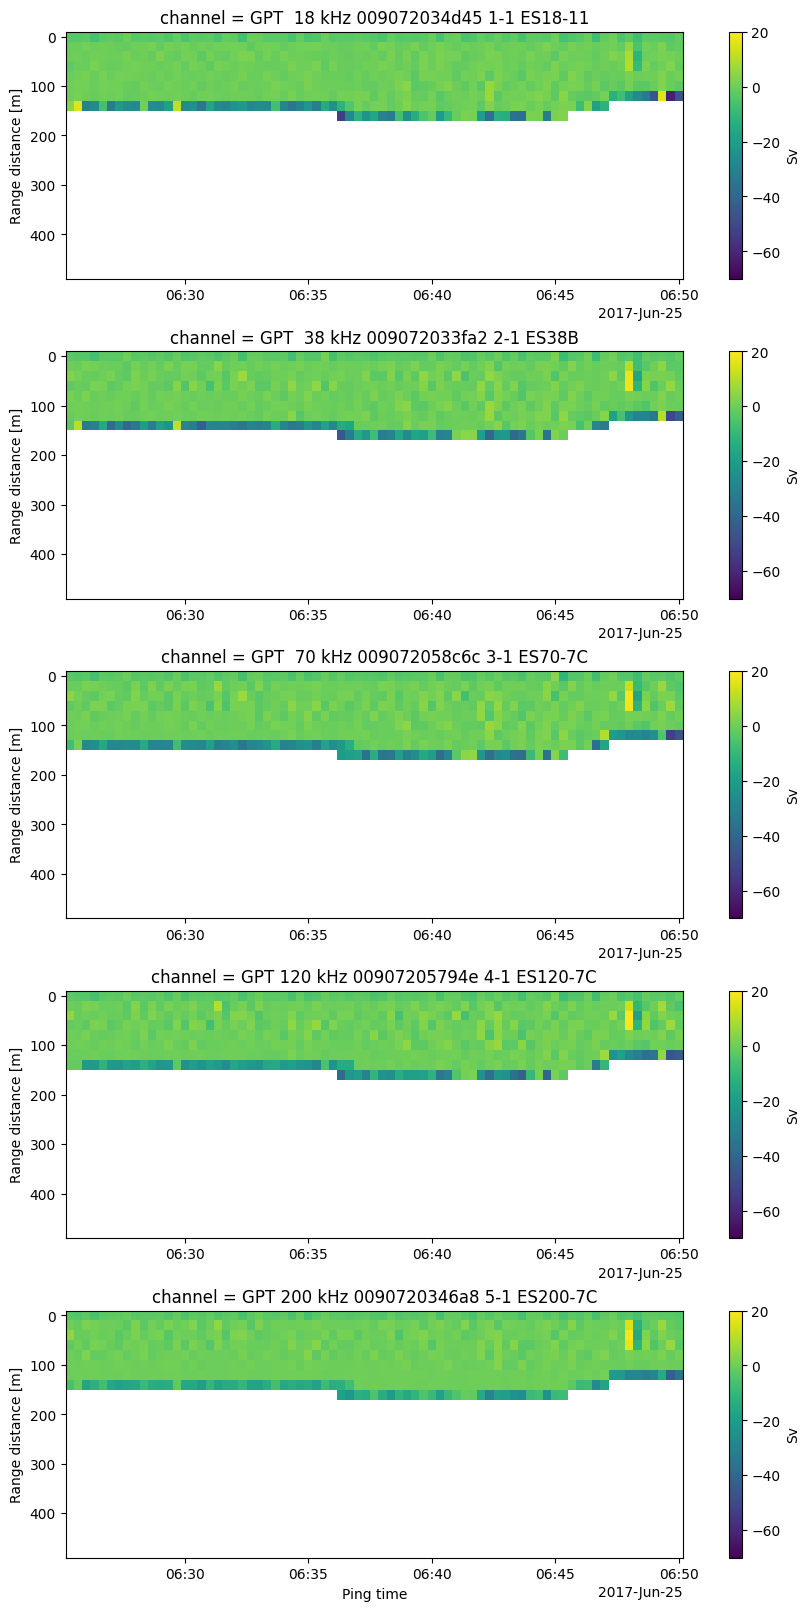

In [159]:
def plot_echograms(ds, column_idx):
    """Plot echograms of the frequencies for xarray dataset ds,
       as a single column of subplots
    """
    for f in range(len(ds.channel)):
        ax = axes[f]
        # Select Sv data by frequency using the frequency_nominal coordinate index "f",
        # then plot the echogram of the selected data
        ds.Sv.isel(channel=f).plot(
            ax=ax, 
            x='ping_time',
            y='echo_range',
            yincrease=False,
            vmin=-70,
            vmax=20,
            cmap="viridis",
        )
        if f < len(ds.channel) - 1:
            ax.set_xlabel(None)

fig, axes = plt.subplots(nrows=len(diff_seabed.channel), ncols=1, constrained_layout=True, figsize=(8, 16))
plot_echograms(diff_seabed, column_idx=0) 

In [ ]:
# Gridded cleaned Sv (all denoise algorithms applied)

In [ ]:
# Gridded background noise removed data

Oceanstream     Echoview
                Sv           Sv
count  3095.000000  3100.000000
mean    -66.270779   -64.011493
std       5.618155     9.504466
min     -90.144364   -86.899900
25%     -69.460669   -68.761868
50%     -65.803764   -65.093788
75%     -62.768456   -61.187816
max     -48.974310   -14.801200

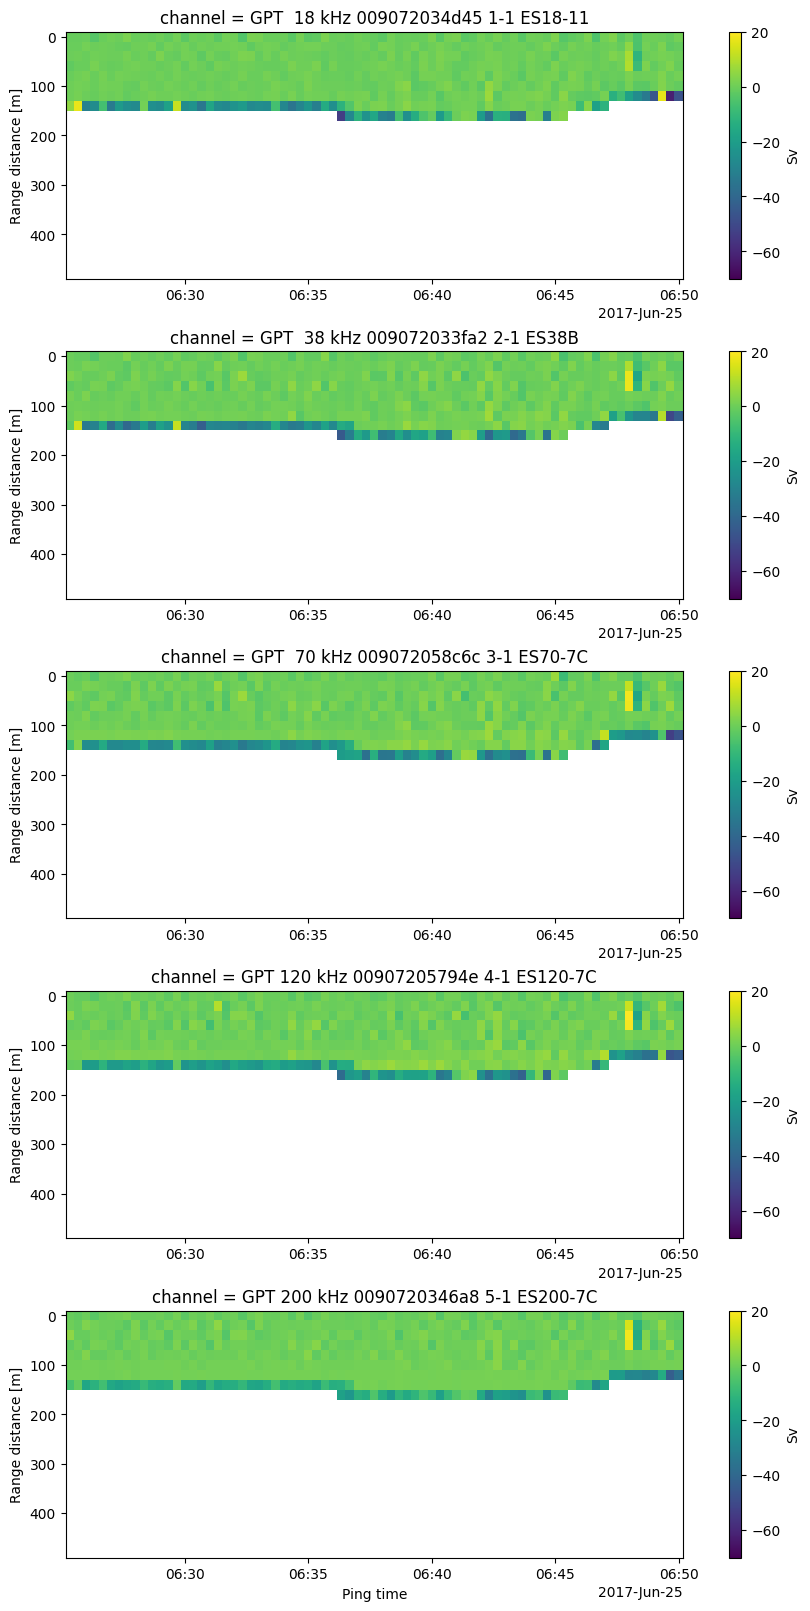

In [76]:
# List all CSV files containing "background" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('.csv') and 'background' in file]
csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files;

# Use the above functions to convert Echoview exported data
echoview_background = create_xarray_dataset(csv_files, dir, 25, 20)

# Copy the coordinates from ds1 to ds2
echoview_background = echoview_background.assign_coords(**MVBS_background.coords)
diff_background = MVBS_background - echoview_background

display(pd.concat([MVBS_background.to_dataframe().describe().iloc[:, 0], echoview_background.to_dataframe().describe()], axis=1, keys=['Oceanstream', 'Echoview']))

fig, axes = plt.subplots(nrows=len(diff_background.channel), ncols=1, constrained_layout=True, figsize=(8, 16))
plot_echograms(diff_background, column_idx=0) 
plt.show()

### Transient noise removed data

Oceanstream     Echoview
                Sv           Sv
count  3095.000000  3100.000000
mean    -66.570239   -67.026786
std       5.504366     8.341030
min     -90.144364   -91.959074
25%     -69.606293   -72.246910
50%     -66.121221   -67.507808
75%     -63.299910   -63.094416
max     -48.974310   -15.558060

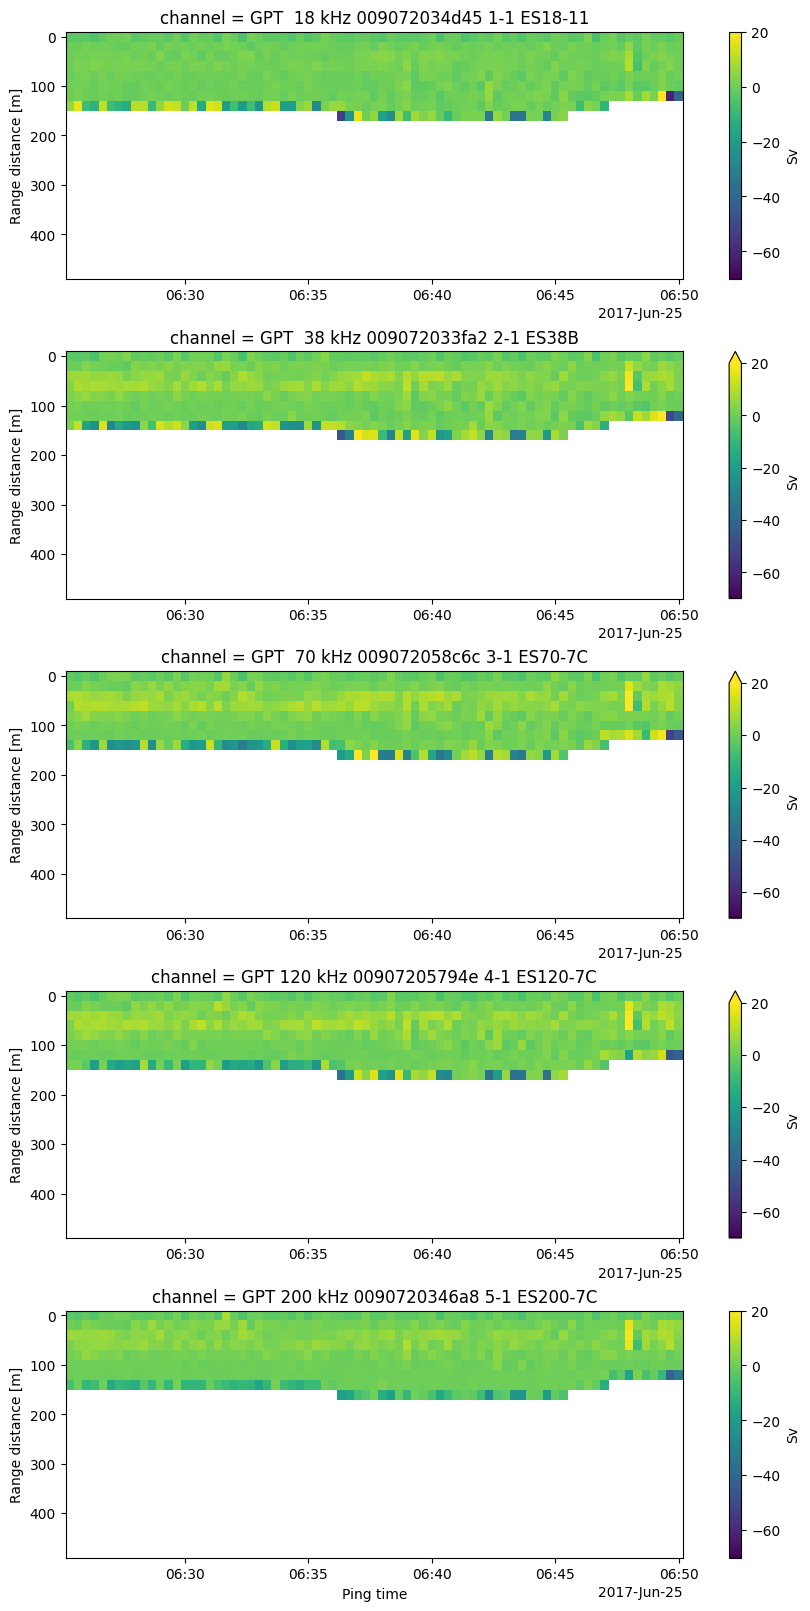

In [78]:
# List all CSV files containing "transient" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('.csv') and 'transient' in file]
csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files;

# Use the above functions to convert Echoview exported data
echoview_transient = create_xarray_dataset(csv_files, dir, 25, 20)

# Copy the coordinates from ds1 to ds2
echoview_transient = echoview_transient.assign_coords(**MVBS_transient.coords)
diff_transient = MVBS_transient - echoview_transient

display(pd.concat([MVBS_transient.to_dataframe().describe().iloc[:, 0], echoview_transient.to_dataframe().describe()], axis=1, keys=['Oceanstream', 'Echoview']))

fig, axes = plt.subplots(nrows=len(diff_transient.channel), ncols=1, constrained_layout=True, figsize=(8, 16))
plot_echograms(diff_transient, column_idx=0) 
plt.show()

### Impulse noise removed data

Oceanstream     Echoview
                Sv           Sv
count  3095.000000  3100.000000
mean    -68.836249   -65.918042
std       5.608818     9.157364
min     -90.697998   -88.779579
25%     -72.301470   -71.652156
50%     -68.891283   -67.040750
75%     -65.214967   -62.510942
max     -51.889299   -19.261416

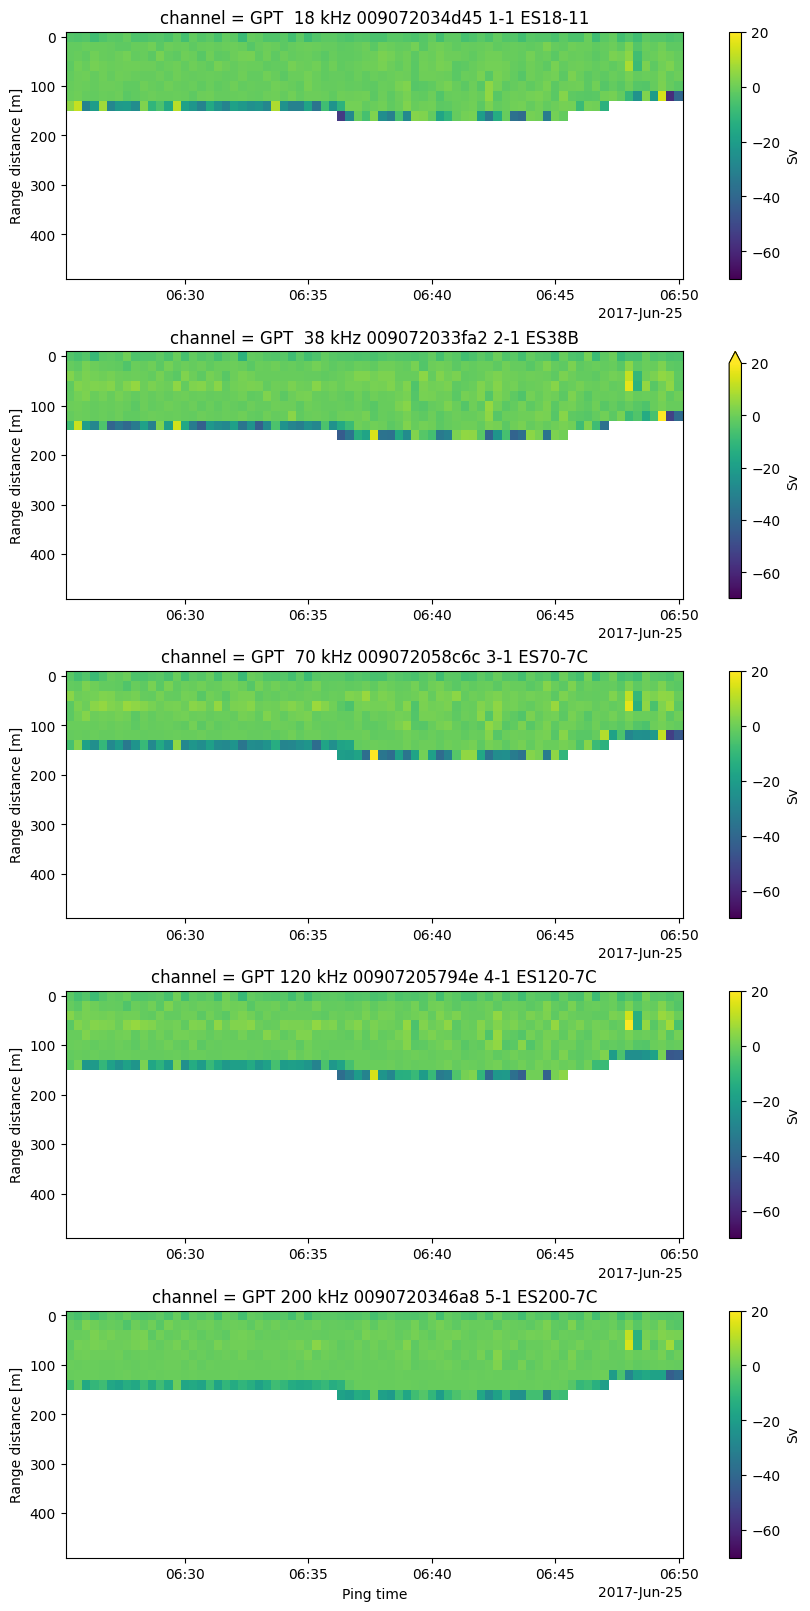

In [79]:
# List all CSV files containing "impulse" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('.csv') and 'impulse' in file]
csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files;

# Use the above functions to convert Echoview exported data
echoview_impulse = create_xarray_dataset(csv_files, dir, 25, 20)

# Copy the coordinates from ds1 to ds2
echoview_impulse = echoview_impulse.assign_coords(**MVBS_impulse.coords)
diff_impulse = MVBS_impulse - echoview_impulse

display(pd.concat([MVBS_impulse.to_dataframe().describe().iloc[:, 0], echoview_impulse.to_dataframe().describe()], axis=1, keys=['Oceanstream', 'Echoview']))

fig, axes = plt.subplots(nrows=len(diff_impulse.channel), ncols=1, constrained_layout=True, figsize=(8, 16))
plot_echograms(diff_impulse, column_idx=0) 
plt.show()

### Attenuated signal removed data

Oceanstream     Echoview
                Sv           Sv
count  3095.000000  3100.000000
mean    -66.570239   -63.747928
std       5.504366     9.232201
min     -90.144364   -86.026791
25%     -69.606293   -68.628568
50%     -66.121221   -64.825491
75%     -63.299910   -61.121848
max     -48.974310   -14.801200

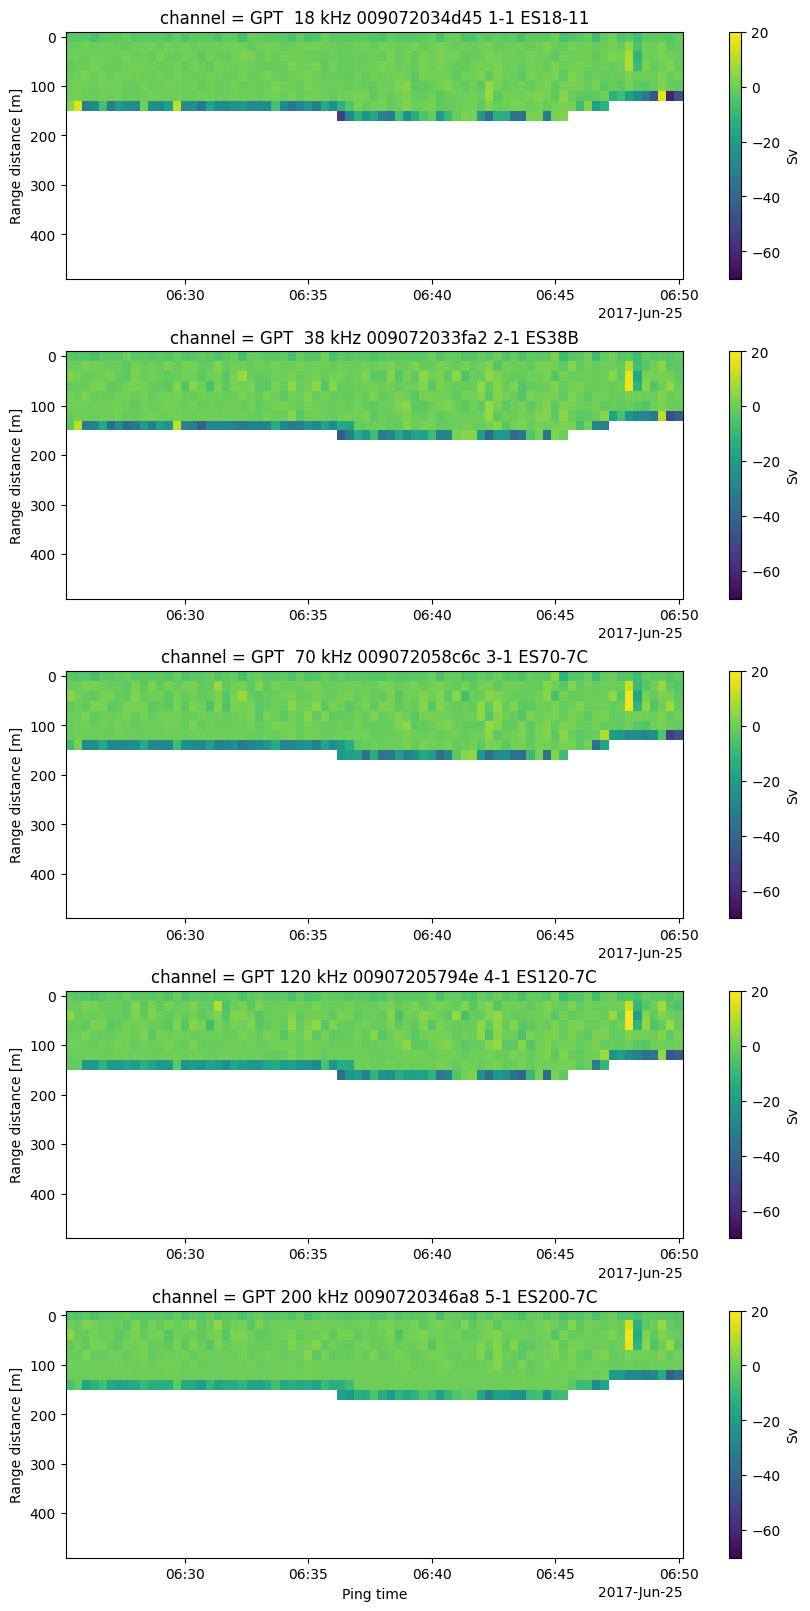

In [81]:
# List all CSV files containing "attenuation" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('.csv') and 'attenuation' in file]
csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files;

# Use the above functions to convert Echoview exported data
echoview_attenuation = create_xarray_dataset(csv_files, dir, 25, 20)

# Copy the coordinates from ds1 to ds2
echoview_attenuation = echoview_attenuation.assign_coords(**MVBS_attenuation.coords)
diff_attenuation = MVBS_attenuation - echoview_attenuation

display(pd.concat([MVBS_attenuation.to_dataframe().describe().iloc[:, 0], echoview_attenuation.to_dataframe().describe()], axis=1, keys=['Oceanstream', 'Echoview']))

fig, axes = plt.subplots(nrows=len(diff_attenuation.channel), ncols=1, constrained_layout=True, figsize=(8, 16))
plot_echograms(diff_attenuation, column_idx=0) 
plt.show()

| Method                       | Oceanstream | Echoview |
|------------------------------|-------------|----------|
| raw Sv                       | -12         | -12      |
| Seabed and surface removal   | 35          | Male     |
| Background removal           |             |          |
| Transient noise removal      |             |          |
| Impulse noise removal        |             |          |
| Attenuation noise removal    |             |          |
| nasc                         |             |          |
| MVBS                         |             |          |
| dB-diff(38-120)              |             |          |
| School detection             |             |          |

### All denoise methods together

Oceanstream     Echoview
                Sv           Sv
count  3095.000000  3100.000000
mean    -68.536423   -74.168519
std       5.692834    73.304591
min     -90.697998  -999.000000
25%     -72.111287   -73.432019
50%     -68.395154   -68.240091
75%     -64.847931   -63.702589
max     -51.889299   -21.230314

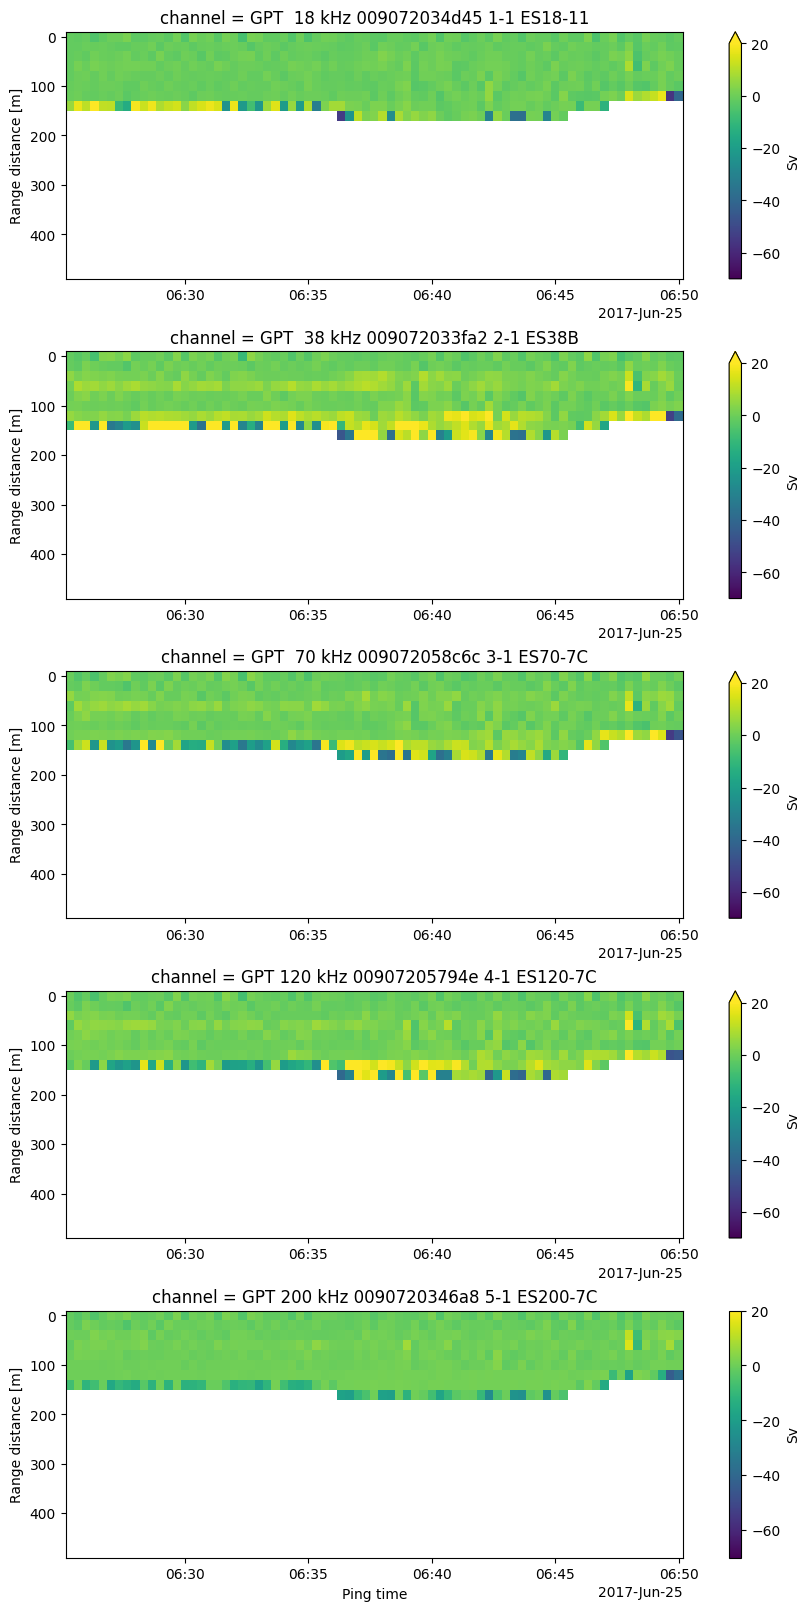

In [83]:
# List all CSV files containing "cleaned" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('grided.csv') and 'cleaned' in file]
csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files;

# Use the above functions to convert Echoview exported data
echoview_cleaned = create_xarray_dataset(csv_files, dir, 25, 20)

# Copy the coordinates from ds1 to ds2
echoview_cleaned = echoview_cleaned.assign_coords(**MVBS_cleaned.coords)
diff_cleaned = MVBS_cleaned - echoview_cleaned

display(pd.concat([MVBS_cleaned.to_dataframe().describe().iloc[:, 0], echoview_cleaned.to_dataframe().describe()], axis=1, keys=['Oceanstream', 'Echoview']))

fig, axes = plt.subplots(nrows=len(diff_cleaned.channel), ncols=1, constrained_layout=True, figsize=(8, 16))
plot_echograms(diff_cleaned, column_idx=0) 
plt.show()

### School/Shoal detection

In [153]:
# List all CSV files containing "krill" in their filename
csv_files = [file for file in os.listdir(dir) if file.endswith('.csv') and 'krill' in file]
#csv_files = sorted(csv_files, key=lambda x: int(x.split('.')[1]))
csv_files

# Use the above functions to convert Echoview exported data
echoview_krill = create_xarray_dataset(csv_files, dir, 25, 20)

# Only show 38 kHz as krill schools are exported on this frequency 
MVBS_krill_sub = MVBS_krill.isel(channel=1)
echoview_krill_sub = echoview_krill.isel(ping_time=slice(0, -1))

MVBS_krill_sub.to_dataframe().describe()
echoview_krill_sub.to_dataframe().describe()
display(pd.concat([MVBS_krill_sub.to_dataframe().describe().iloc[:, 0], echoview_krill_sub.to_dataframe().describe().iloc[:, 0]], axis=1, keys=['Oceanstream', 'Echoview']))

Oceanstream    Echoview
count   348.000000  622.000000
mean    -68.351213 -267.152726
std       3.803359  365.597186
min     -85.316699 -999.000000
25%     -70.564593 -101.789713
50%     -68.412267  -87.273176
75%     -65.790429  -79.503974
max     -53.335606  -30.041975

## Sv data comparison by sample point level

## NASC (abundance index)

In [170]:
nasc_seabed     
nasc_background
nasc_attenuation                                
nasc_impulse                                                
nasc_transient
nasc_cleaned 

{'NASC_dataset': <xarray.Dataset> Size: 160B
 Dimensions:            (channel: 5, distance: 1, depth: 1)
 Coordinates:
   * distance           (distance) float64 8B 0.0
   * channel            (channel) object 40B 'GPT  18 kHz 009072034d45 1-1 ES1...
   * depth              (depth) float64 8B 0.0
 Data variables:
     NASC               (channel, distance, depth) float64 40B 1.684e+04 ... 6...
     latitude           (distance) float64 8B 55.34
     longitude          (distance) float64 8B -159.4
     ping_time          (distance) datetime64[ns] 8B 2017-06-25T06:37:40.79090...
     frequency_nominal  (channel) float64 40B 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
 Attributes:
     Conventions:           CF-1.7,ACDD-1.3
     time_coverage_start:   2017-06-25T06:25:21.886674944Z
     time_coverage_end:     2017-06-25T06:50:03.298446848Z
     geospatial_lat_min:    55.30328
     geospatial_lat_max:    55.3747
     geospatial_lon_min:    -159.45116
     geospatial_lon_max:    -159.37819
     pro

In [ ]:
# import Echoview exported NASC